# Importing Libraries

In [1]:
from shapely.geometry import Point, LineString, shape
import matplotlib.pyplot as plt # Importing Libraries
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/Insert-Generic-Name-Here/'))
# sys.path

from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
from lonelyboy.geospatial import group_patterns_v2 as gsgp

# Read the (subseted) Dataset
* ### Clear the Duplicates
* ### Order by Timestamp

In [3]:
traj = pd.read_pickle('data/subseted.pckl')
# traj = pd.read_csv('data/205067000.csv')
traj['geom'] = np.nan
traj = gspp.gdf_from_df(traj)

ports = pd.read_pickle('data/ports_raw.pkl')
ports.crs = {'init' :'epsg:4326'}

traj = gpd.GeoDataFrame(traj, geometry='geom')
traj.crs = {'init' :'epsg:4326'}

In [4]:
traj.drop_duplicates(subset=['mmsi', 'ts'], inplace=True)
traj.sort_values('ts', inplace=True)
traj.head()

,mmsi,speed,lon,lat,ts,geom
12293629,227941000,0.0,-4.327213,48.100086,1456802711,POINT (-4.3272133 48.100086)
12293630,227705102,0.0,-4.496568,48.382435,1456802711,POINT (-4.496568 48.382435)
17515086,256494000,0.0,-4.451149,48.383625,1456802713,POINT (-4.4511485 48.383625)
12293633,227574020,0.0,-4.496673,48.382454,1456802713,POINT (-4.496673 48.382454)
17515085,227300000,2.8,-4.631805,48.111330,1456802713,POINT (-4.631805 48.11133)


In [5]:
ports.head()

,gid,gml_id,por_id,libelle_po,insee_comm,por_x,por_y,geom
0,1,port.1,1,Le Vivier-sur-Mer,35361,297025.0,2408370.0,POINT (-1.771798868659233 48.60274269672541)
1,2,port.10,10,Saint-Samson sur Rance,22327,279335.0,2396060.0,POINT (-2.001990119062326 48.48369993456267)
2,3,port.100,100,Douarnenez,29046,103135.0,2365330.0,POINT (-4.341204251638414 48.09709590770091)
3,4,port.101,101,Brézellec,29028,79105.4,2364190.0,POINT (-4.661115947908725 48.06804110561076)
4,5,port.102,102,Sein,29083,64562.5,2362180.0,POINT (-4.852944548180974 48.03825273921113)


# Plot the Dataset 
* ### Plot the raw GPS data points
* ### Plot the corresponding LineStrings per vessel
##### (for presentation purposes we plot - and test - only for vessel \w mmsi=226178000)

In [6]:
traj_ls = traj.groupby(['mmsi'])['geom'].apply(lambda x: LineString(x.tolist() if len(x.tolist())>1 else 2*x.tolist()))    
traj_ls = gpd.GeoDataFrame(traj_ls, geometry='geom')
traj_ls.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

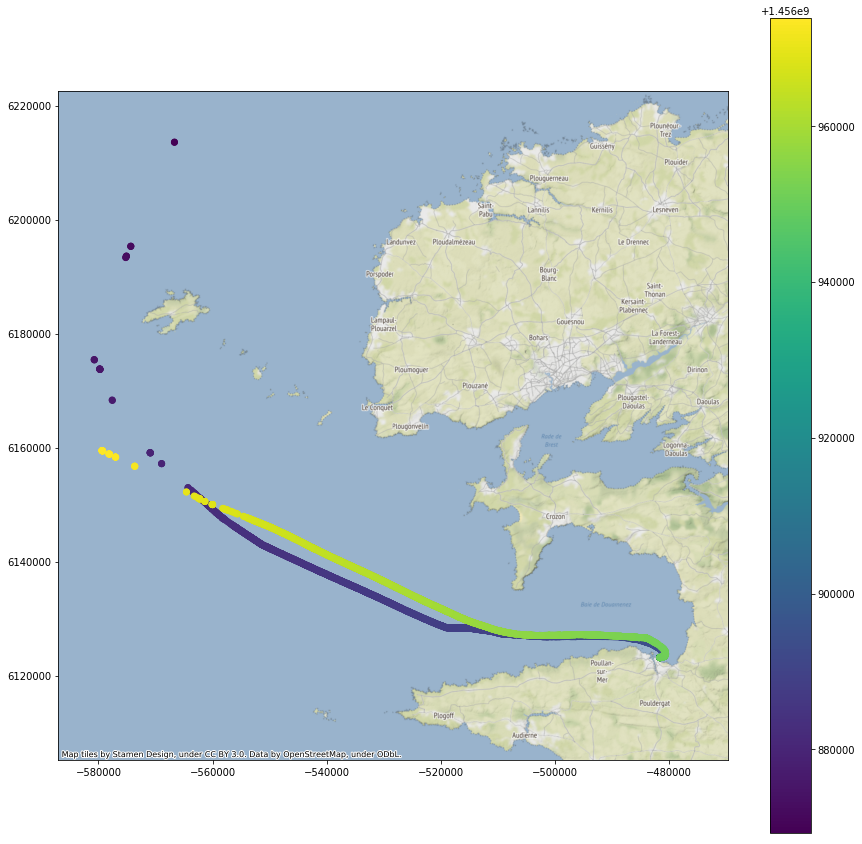

In [7]:
plt.figure(1)
# df.loc[df.mmsi==226178000].plot()
# ax = traj.loc[traj.mmsi==226178000].plot()
# traj_ls.loc[traj_ls.mmsi==226178000].plot(ax=ax)
gsplt.map_plot(traj.loc[traj.mmsi==226178000], column='ts', legend=True)
# gsplt.map_plot(traj, column='ts', legend=True)

## Compressing our Trajectory using the Ramer-Douglas-Peucker algorithm

In [8]:
sample_traj = traj.loc[traj.mmsi==226178000]
sample_traj_pts = traj.loc[traj.mmsi==226178000].geom.apply(lambda x: pd.Series([x.x,x.y])).values
# sample_traj = traj
# sample_traj_pts = traj.geom.apply(lambda x: pd.Series([x.x,x.y])).values
sample_traj_pts

array([[-5.0904784, 48.637615 ],
       [-5.090585 , 48.637352 ],
       [-5.159165 , 48.529205 ],
       ...,
       [-5.2046866, 48.315468 ],
       [-5.204787 , 48.3155   ],
       [-5.204925 , 48.315544 ]])

In [9]:
# traj.to_crs(epsg=3310) # for euclidean distance in meters (not radians)

In [10]:
from scipy.spatial.distance import pdist, squareform

distances = pdist(sample_traj_pts, metric='euclidean')
dist_matrix = squareform(distances)

In [11]:
import rdp
import tqdm 

n_theta = 50
meanDist = (np.min(dist_matrix) + np.max(dist_matrix))/2
theta_min = 0.25 * meanDist; theta_max = 1.75 * meanDist
s = (theta_max - theta_min)/(n_theta - 1)

print (f'min epsilon: {theta_min}\nmax epsilon: {theta_max}\nstep: {s}')

total_segments = []
for i in tqdm.tqdm(np.arange(theta_min, theta_max, s)):
    mask = rdp.rdp(sample_traj_pts, epsilon=i, algo="iter", return_mask=True)
    total_segments.append([len(mask[mask==True])-1, i])
    
total_segments = np.vstack(total_segments)

  0%|          | 0/49 [00:00<?, ?it/s]

min epsilon: 0.1189488456106998
max epsilon: 0.8326419192748986
step: 0.014565164768657119


100%|██████████| 49/49 [00:32<00:00,  1.68it/s]


In [12]:
opt_seg = np.bincount(total_segments[:,0].astype(np.int64)).argmax()
opt_epsilon = np.mean(total_segments[np.where(total_segments==opt_seg)[0]][:, 1])
print (f'Optimal #Segments: {opt_seg}')
print (f'Optimal epsilon: {opt_epsilon}')

mask = rdp.rdp(sample_traj_pts, epsilon=opt_epsilon, algo="iter", return_mask=True)
print(f'Segments found: {len(mask[mask==True])-1}')
sample_traj_pts[mask]

Optimal #Segments: 2
Optimal epsilon: 0.5559037886704138
Segments found: 2


array([[-5.0904784, 48.637615 ],
       [-4.3171816, 48.10116  ],
       [-5.204925 , 48.315544 ]])

### Plotting the RDP Result vs, the Initial Data

#### NOTE: The Mask can be used to fetch the points with their accompanying data (@traj DataFrame)

<Figure size 432x288 with 0 Axes>

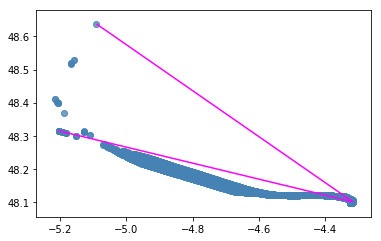

In [13]:
# points_after_rdp = gpd.GeoSeries(list(zip(testMatrix[:,0], testMatrix[:,1]))).map(Point)
sample_traj_after_rdp = traj.loc[traj.mmsi==226178000].loc[mask]
# sample_traj_after_rdp = traj.loc[mask]

sample_traj_rdp_ls = sample_traj_after_rdp.groupby(['mmsi'])['geom'].apply(lambda x: LineString(x.tolist() if len(x.tolist())>1 else 2*x.tolist()))    
sample_traj_rdp_ls = gpd.GeoDataFrame(sample_traj_rdp_ls, geometry='geom')
sample_traj_rdp_ls.reset_index(inplace=True)

# plt.figure(2)
# ax = points_after_rdp.plot()
# df2.plot(ax=ax)

# plt.figure(3)
# ax = traj.loc[traj.mmsi==226178000].plot()
# df.loc[df.mmsi==226178000].plot(ax=ax)

plt.figure(2)
ax = sample_traj.plot(color='steelblue', alpha=0.5)
sample_traj_rdp_ls.plot(ax=ax, color='magenta')

In [14]:
def create_labels(gdf, pois):
    for idx, poi_ts in enumerate(pois.ts[1:]):
        gdf.at[((gdf.ts <= poi_ts) & (gdf.traj_id == -1)), 'traj_id'] = idx
    return gdf
    
sample_traj['traj_id'] = -1
sample_traj = create_labels(sample_traj, sample_traj_after_rdp)
sample_traj

/home/andretri7/anaconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/andretri7/anaconda3/envs/gis/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,mmsi,speed,lon,lat,ts,geom,traj_id
17534481,226178000,8.5,-5.090478,48.637615,1456869231,POINT (-5.0904784 48.637615),0
17534492,226178000,8.2,-5.090585,48.637352,1456869238,POINT (-5.090585 48.637352),0
17536081,226178000,8.6,-5.159165,48.529205,1456872202,POINT (-5.159165 48.529205),0
17536087,226178000,8.4,-5.159310,48.528990,1456872207,POINT (-5.15931 48.52899),0
17536092,226178000,8.4,-5.159385,48.528885,1456872210,POINT (-5.159384999999999 48.528885),0
17536306,226178000,8.4,-5.166130,48.518900,1456872491,POINT (-5.16613 48.5189),0
17536311,226178000,8.4,-5.166303,48.518654,1456872499,POINT (-5.166303 48.518654),0
17536314,226178000,8.4,-5.166350,48.518580,1456872501,POINT (-5.16635 48.51858),0
17536331,226178000,8.4,-5.167112,48.517475,1456872531,POINT (-5.167112 48.517475),0
17536333,226178000,8.4,-5.167297,48.517235,1456872539,POINT (-5.167297 48.517235),0


In [15]:
sample_traj_after_rdp

,mmsi,speed,lon,lat,ts,geom
17534481,226178000,8.5,-5.090478,48.637615,1456869231,POINT (-5.0904784 48.637615)
17557635,226178000,6.5,-4.317182,48.101160,1456951018,POINT (-4.3171816 48.10116)
17566605,226178000,5.7,-5.204925,48.315544,1456973939,POINT (-5.204925 48.315544)


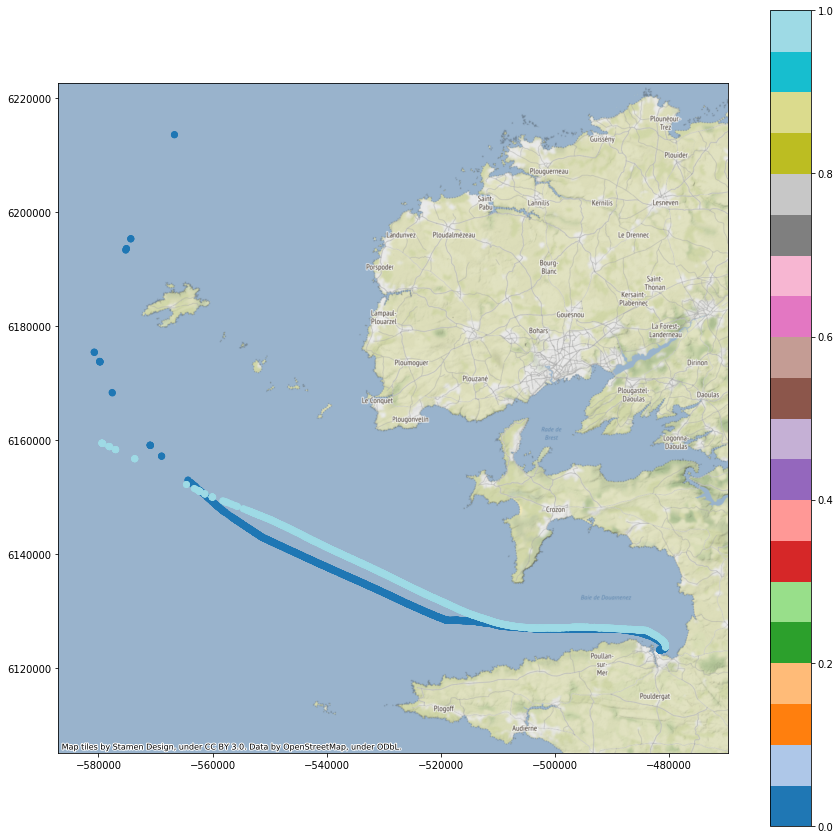

In [16]:
# sample_traj.plot(column='traj_id', cmap='tab20')
gsplt.map_plot(sample_traj, column='traj_id', cmap='tab20', legend=True)

## Passing Simplified Trajectory to our Implementation (Segmentation via Anomaly Detection in Vessel Acceleration for further POI filtering, i.e. getting the final POIs)

In [17]:
sample_traj_after_rdp['velocity'] = np.nan
sample_traj_after_rdp = sample_traj_after_rdp.groupby(['mmsi'], as_index=False).apply(gspp.calculate_velocity, smoothing=False, window=15, center=False).reset_index(drop=True)
sample_traj_after_rdp.head()

,mmsi,speed,lon,lat,ts,geom,velocity
0,226178000,8.5,-5.090478,48.637615,1456869231,POINT (-5.0904784 48.637615),2.48455
1,226178000,6.5,-4.317182,48.101160,1456951018,POINT (-4.3171816 48.10116),0.00000


In [18]:
pois_alpha=-1 
gspp.segment_trajectories(sample_traj_after_rdp, pois_alpha=pois_alpha, pois_window=80, n_jobs=-1, np_split=True, feature='mmsi')

starting..
1


,mmsi,speed,lon,lat,ts,geom,velocity,traj_id,pois
0,226178000,8.5,-5.090478,48.637615,1456869231,POINT (-5.0904784 48.637615),2.48455,0,"[0, 1]"
1,226178000,6.5,-4.317182,48.101160,1456951018,POINT (-4.3171816 48.10116),0.00000,0,"[0, 1]"
